# $ \overline{(SST')^2}$: Gaussian vs. Taper filter

In [1]:
import gcm_filters
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy
import cmocean

In [2]:
list(gcm_filters.GridType)

[<GridType.CARTESIAN: 1>,
 <GridType.CARTESIAN_WITH_LAND: 2>,
 <GridType.IRREGULAR_CARTESIAN_WITH_LAND: 3>,
 <GridType.POP_SIMPLE_TRIPOLAR_T_GRID: 4>,
 <GridType.POP_TRIPOLAR_T_GRID: 5>]

## Open POP 0.1 degree data

In [3]:
ds = xr.open_dataset('/glade/work/igrooms/current_data', decode_times=False)

### Make ocean ("wet") mask

In [4]:
wet_mask = xr.where(ds['KMT']>0,1,0)

Text(0.5, 1.0, 'wet_mask')

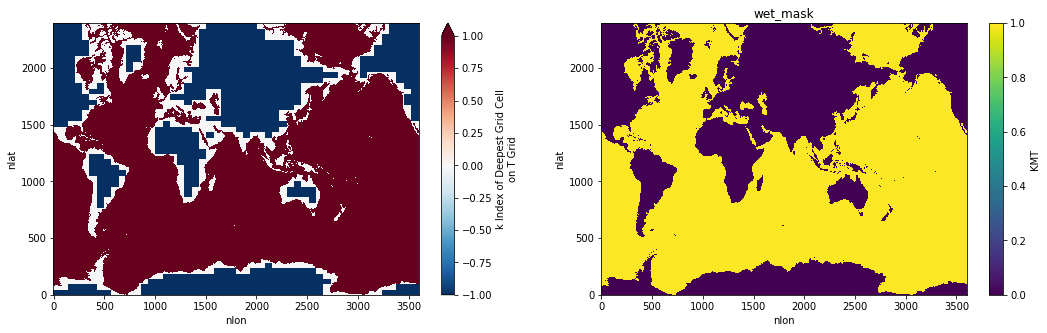

In [5]:
fig,axs = plt.subplots(1,2,figsize=(18,5))
ds.KMT.plot(ax=axs[0],vmin=ds.KMT.min())
wet_mask.plot(ax=axs[1])
axs[1].set_title('wet_mask')

## Define spatial filters

### Fixed factor Gaussian

In [6]:
filter_Gaussian = gcm_filters.Filter(
    filter_scale=10,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=0,  # default number of steps
    grid_type=gcm_filters.GridType.POP_SIMPLE_TRIPOLAR_T_GRID,
    grid_vars={'wet_mask': wet_mask}
)
filter_Gaussian

n_steps = 18


Filter(filter_scale=10, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=0, grid_type=<GridType.POP_SIMPLE_TRIPOLAR_T_GRID: 4>)

### Fixed factor Taper

In [7]:
filter_Taper = gcm_filters.Filter(
    filter_scale=10,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.TAPER,
    n_steps=0,  # default number of steps
    grid_type=gcm_filters.GridType.POP_SIMPLE_TRIPOLAR_T_GRID,
    grid_vars={'wet_mask': wet_mask}
)
filter_Taper

n_steps = 64


Filter(filter_scale=10, dx_min=1, filter_shape=<FilterShape.TAPER: 2>, transition_width=3.141592653589793, ndim=2, n_steps=0, grid_type=<GridType.POP_SIMPLE_TRIPOLAR_T_GRID: 4>)

### Filter SST with the 2 filters

In [21]:
SST = ds['TEMP'].isel(z_t=0,time=-1).where(wet_mask) 

In [22]:
SST_filtered_Gaussian = filter_Gaussian.apply(SST*ds['TAREA'], dims=['nlat', 'nlon'])
SST_filtered_Gaussian = SST_filtered_Gaussian/(ds['TAREA'].where(wet_mask))

SST_filtered_Taper = filter_Taper.apply(SST*ds['TAREA'], dims=['nlat', 'nlon'])
SST_filtered_Taper = SST_filtered_Taper/(ds['TAREA'].where(wet_mask))

### Compute
$$
    \overline{(SST')^2}
$$
where $SST' = SST - \overline{SST}$.

In [23]:
SSTprime_Gaussian = SST - SST_filtered_Gaussian
SSTprime_Taper = SST - SST_filtered_Taper

SSTcross_Gaussian = filter_Gaussian.apply(SSTprime_Gaussian**2*ds['TAREA'], dims=['nlat', 'nlon'])
SSTcross_Gaussian = SSTcross_Gaussian/(ds['TAREA'].where(wet_mask))
SSTcross_Taper = filter_Taper.apply(SSTprime_Taper**2*ds['TAREA'], dims=['nlat', 'nlon'])
SSTcross_Taper = SSTcross_Taper/(ds['TAREA'].where(wet_mask))

### Agulhas domain: around southern tip of Africa

In [74]:
nlon0 = 1220
nlon1 = 1449
nlat0 = 677
nlat1 = 900
xslice = slice(nlon0,nlon1)
yslice = slice(nlat0,nlat1)

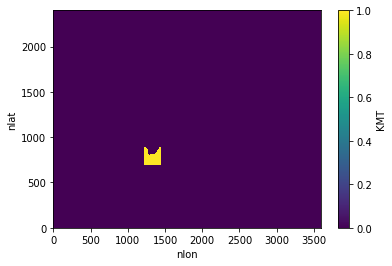

In [75]:
wet_mask_domain = wet_mask.copy()
wet_mask_domain[:, None:1220] = 0
wet_mask_domain[:, 1449:None] = 0
wet_mask_domain[None:700, :] = 0
wet_mask_domain[900:None, :] = 0

wet_mask_Agulhas = wet_mask_domain * wet_mask
wet_mask_Agulhas.plot()

In [73]:
ds.TLONG[677,1220].values

array(12.05)

In [62]:
ds.TLONG[900,1449].values

array(34.95)

In [70]:
ds.TLAT[677,1220].values

array(-44.9775907)

In [72]:
ds.TLAT[900,1449].values

array(-27.08655334)

[Text(0.5, 1.0, 'difference in $\\overline{(SST^\\prime)^2}$: Gaussian - Taper')]

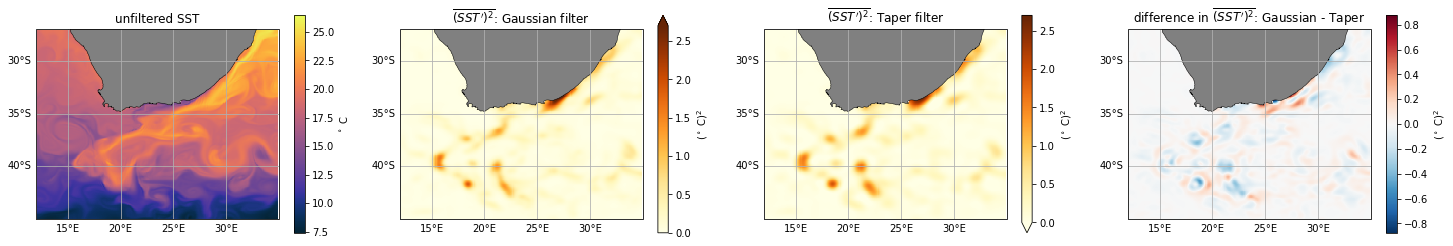

In [99]:
# Agulhas
fig,axs = plt.subplots(1,4,figsize=(25,4),subplot_kw={'projection':ccrs.PlateCarree()})
        
SST.isel(nlon=xslice,nlat=yslice).plot(ax=axs[0],x='ULONG',y='ULAT',
                                            cmap=cmocean.cm.thermal,
                                            #vmin=vmin,vmax=vmax,
                                            cbar_kwargs={"label": r'$^\circ$ C'},
                                            transform=ccrs.PlateCarree())
SSTcross_Gaussian.isel(nlon=xslice,nlat=yslice).plot(ax=axs[1],x='ULONG',y='ULAT',
                                            cmap='YlOrBr',
                                            vmin=0,
                                            vmax=2.7,
                                            cbar_kwargs={"label": r'($^\circ$ C)$^2$'},
                                            transform=ccrs.PlateCarree())
 
SSTcross_Taper.isel(nlon=xslice,nlat=yslice).plot(ax=axs[2],x='ULONG',y='ULAT',
                                               cmap='YlOrBr',
                                                vmin=0,
                                                vmax=2.7,
                                                #vmin=vmin,vmax=vmax,
                                                cbar_kwargs={"label": r'($^\circ$ C)$^2$'},
                                                transform=ccrs.PlateCarree())

(SSTcross_Gaussian-SSTcross_Taper).isel(nlon=xslice,nlat=yslice).plot(ax=axs[3],x='ULONG',y='ULAT',
                                               cmap='RdBu_r',
                                                #vmin=vmin,vmax=vmax,
                                                cbar_kwargs={"label": r'($^\circ$ C)$^2$'},
                                                transform=ccrs.PlateCarree())
for ax in axs.flatten():
    ax.set_extent([12, 35, -45, -27], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator([15,20,25,30,35])
    gl.ylocator = mticker.FixedLocator([-45,-40,-35,-30])

    land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',linewidth=0.5, edgecolor='black', facecolor='gray'))  
    
axs[0].set(title='unfiltered SST')
axs[1].set(title=r'$\overline{(SST^\prime)^2}$: Gaussian filter')
axs[2].set(title=r'$\overline{(SST^\prime)^2}$: Taper filter')
axs[3].set(title=r'difference in $\overline{(SST^\prime)^2}$: Gaussian - Taper')

#plt.savefig('figures/SST_boundary_unaware.png',dpi=400,bbox_inches='tight',pad_inches=0)

In the third plot, there are actually negative values down to -0.21:

In [90]:
SSTcross_Taper.isel(nlon=xslice,nlat=yslice).min().values

array(-0.21486261)

Max value in this domain for Taper:

In [92]:
SSTcross_Taper.isel(nlon=xslice,nlat=yslice).max().values

array(2.66568919)

Max value in this domain for Gaussian:

In [93]:
SSTcross_Gaussian.isel(nlon=xslice,nlat=yslice).max().values

array(3.04889375)

### Compute integrals of cross term

Global:

In [84]:
global_Gaussian = (SSTcross_Gaussian.where(wet_mask) * ds['TAREA']).sum().values
global_Taper = (SSTcross_Taper.where(wet_mask) * ds['TAREA']).sum().values

print('global integrals; Gaussian: %g; Taper: %g' %(global_Gaussian, global_Taper))

global integrals; Gaussian: 1.12083e+17; Taper: 1.15619e+17


Agulhas domain:

In [85]:
domain_Gaussian = (SSTcross_Gaussian.where(wet_mask_Agulhas) * ds['TAREA']).sum().values
domain_Taper = (SSTcross_Taper.where(wet_mask_Agulhas) * ds['TAREA']).sum().values

print('Agulhas domain integrals; Gaussian: %g; Taper: %g' %(domain_Gaussian, domain_Taper))

Agulhas domain integrals; Gaussian: 4.42271e+15; Taper: 4.53391e+15
